In [100]:
import importlib

libraries = [
    "tensorflow",
    "numpy",
    "spektral",
    "matplotlib",
    "pandas",
    "dumb",
    "spam"
]

for lib in libraries:
    try:
        if not importlib.util.find_spec(lib):
            raise ImportError("Package '%s' is not installed" % lib)
    except ImportError as e:
        print(e)

Package 'dumb' is not installed
Package 'spam' is not installed


### Soil moisture data preprocessing

In [15]:
import numpy as np

def load_italy():
    return np.load("Italy_data.npy")

(45, 70, 732)


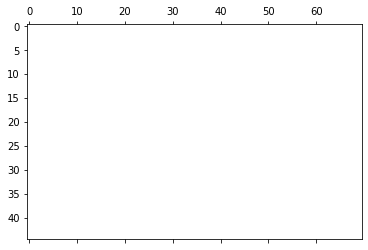

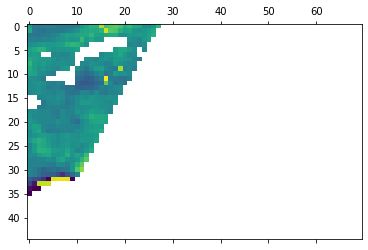

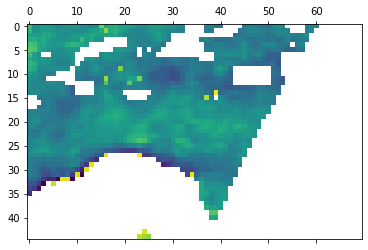

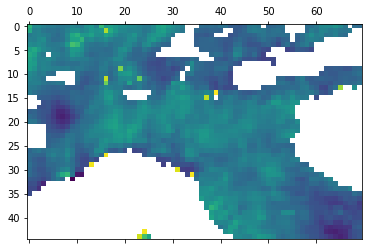

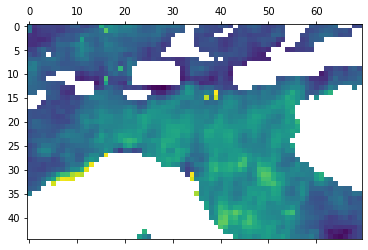

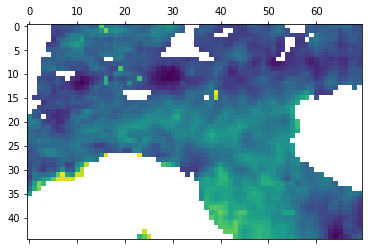

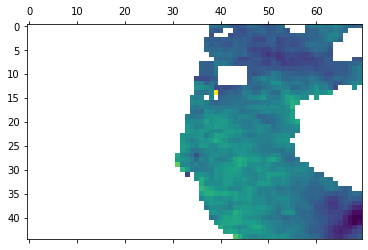

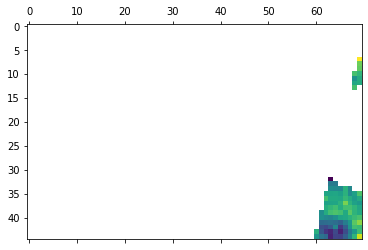

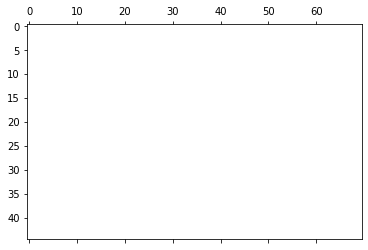

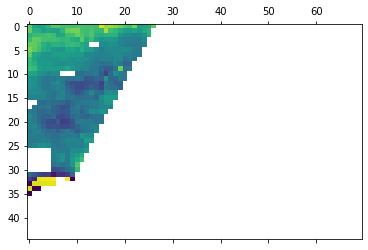

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

italy = load_italy()

for i in range(10):
    fig, ax = plt.subplots()
    ax.matshow(italy[..., i * 10])
    plt.show()

In [35]:
print("Max: %s" % np.nanmax(italy))
print("Min: %s" % np.nanmin(italy))
print("Missing value ratio: %s" % (np.sum(np.isnan(italy)) / np.prod(italy.shape)))
print("Data shape: {}".format(italy.shape))

Max: 0.63700736
Min: 0.02
Missing value ratio: 0.6044509497788186
Data shape: (45, 70, 732)


**Write a function which linearly interpolates to fill missing data**

We will use the `pandas` library to make a `Dataframe` that can easily be interpolated linearly to fill missing values.

We will assume that the array has nodes along the first dimension and time along the second (and last) dimension.

In [101]:
def lin_interp(data):
    """
    data: array (Last axis MUST be time!)
    """
    ndim = data.ndim
    in_shape = data.shape
    if ndim > 2:
        data = data.reshape(-1, data.shape[-1])
    return pd.DataFrame(data.T).interpolate(method="linear", limit_direction="forward").interpolate(method="linear",
                                                                                                    limit_direction="backward").values.T

To show this in operation, here is an example, before and after interpolation. Note that if there are no observed values over time the `nan` values aren't filled.

In [107]:
test_array = np.array([[1., np.nan, np.nan, 7.], [np.nan, 2., 3., np.nan], [np.nan, np.nan, np.nan, np.nan], [np.nan, 3., np.nan, 5]])

print("Before:")
print(test_array)
print()
print("After:")
print(lin_interp(test_array))

Before:
[[ 1. nan nan  7.]
 [nan  2.  3. nan]
 [nan nan nan nan]
 [nan  3. nan  5.]]

After:
[[ 1.  3.  5.  7.]
 [ 2.  2.  3.  3.]
 [nan nan nan nan]
 [ 3.  3.  4.  5.]]


**Write a function to normalize the data between 0 and 1 (if not already)**

Generally speaking, it is common practice to normalize features in the data before using deep learning methods. This ensures that gradients will be comparable across features and applications which means that there is less need to tune optimization parameters such as learning rates/momentum etc.

We will again assume that the function input will be a 2-dimensional array with #nodes x #timesteps.

In [108]:
def normalize(data):
    maximum = np.nanmax(data, axis=0, keepdims=True)
    minimum = np.nanmin(data, axis=0, keepdims=True)
    return (data - minimum) / (maximum - minimum)

In [111]:
test_array = np.array(np.array([[1,2,3],[4,1,1], [3., 1., 3.5]]))

print("Before:")
print(test_array)
print()
print("After:")
print(normalize(test_array))

Before:
[[1.  2.  3. ]
 [4.  1.  1. ]
 [3.  1.  3.5]]

After:
[[0.         1.         0.8       ]
 [1.         0.         0.        ]
 [0.66666667 0.         1.        ]]


**Use of functions to process data and save**

In [117]:
filled = lin_interp(italy.reshape(-1, italy.shape[-1]))
normalized = normalize(filled)

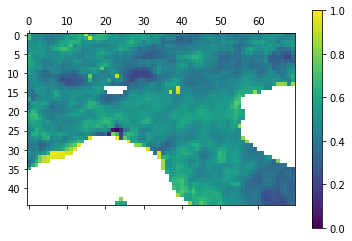

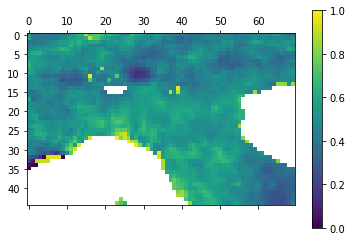

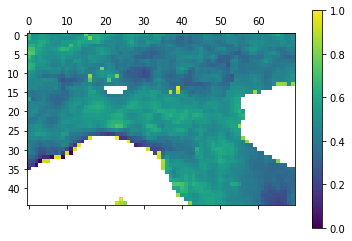

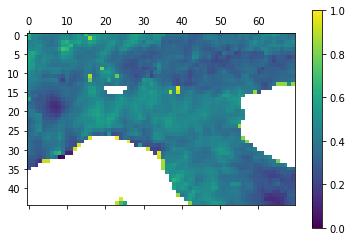

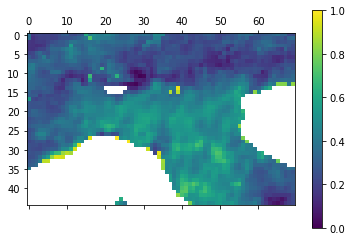

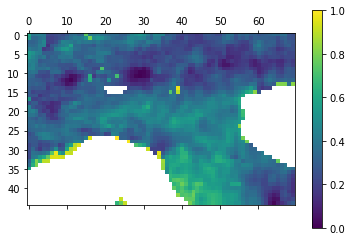

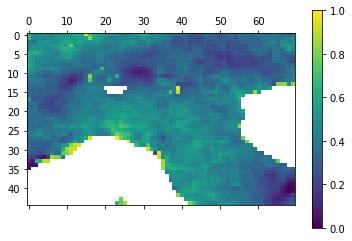

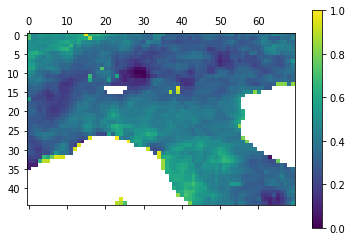

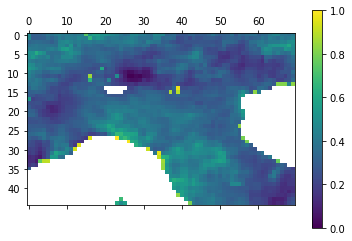

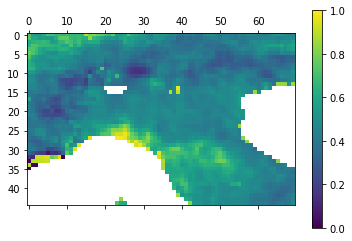

In [124]:
reshaped = normalized.reshape(italy.shape)

for i in range(10):
    fig, ax = plt.subplots()
    cm = ax.matshow(normalized.reshape(italy.shape)[..., i * 10])
    fig.colorbar(cm, ax=ax)
    plt.show()

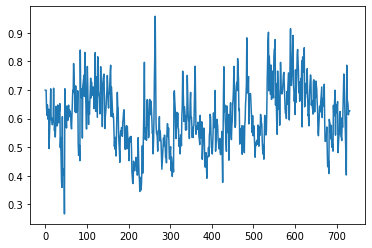

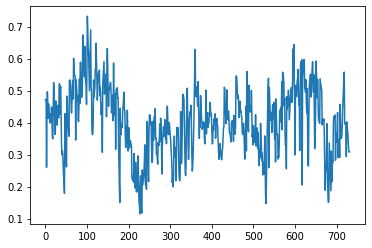

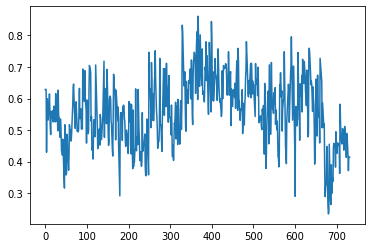

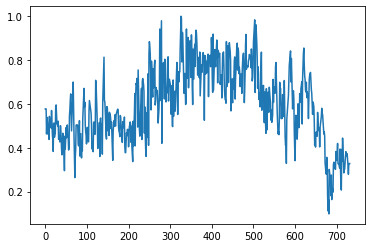

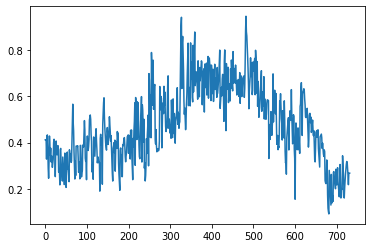

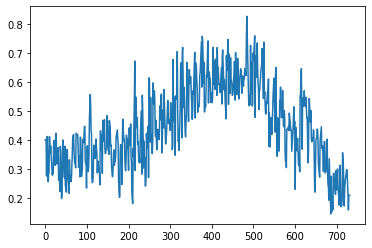

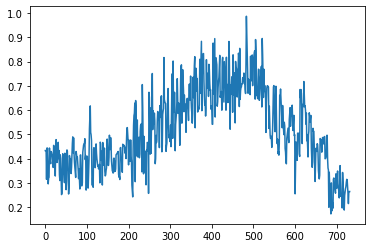

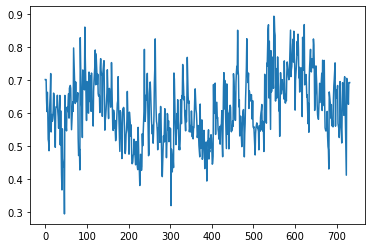

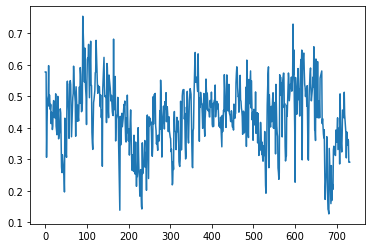

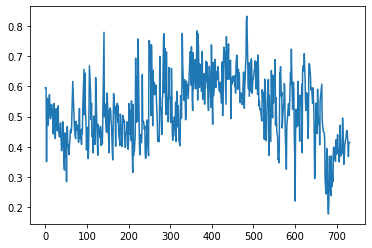

In [128]:
for i in range(10):
    plt.plot(normalized[i * 10])
    plt.show()

# Uncertainty-aware graph-based classification

## Prep-work

### __Useful functions__

**Compute vacuity uncertainty**

Write a function which computes vacuity uncertainty from Dirichlet parameters.

Assume input is of shape (N, K), i.e. #nodes x #classes.

Output should be of shape (N,)

In [38]:
def get_vacuity(alphas):
    return alphas.shape[1] / np.sum(alphas, axis=1)

In [39]:
get_vacuity(np.array([[1,2,3],[1,1,1]]))

array([0.5, 1. ])

**Get belief mass vector from alpha vectors**

In [55]:
def get_belief(alphas):
    return (alphas - 1) / np.sum(alphas, axis=1, keepdims=True)

In [56]:
get_belief(np.array([[1,2,3],[1,1,1]]))

array([[0.        , 0.16666667, 0.33333333],
       [0.        , 0.        , 0.        ]])

**Compute dissonance uncertainty**

Write a function which computes dissonance uncertainty from Dirichlet parameters.

Assume input is of shape (N, K), i.e. #nodes x #classes.

Output should be of shape (N,)

In [65]:
def dissonance_uncertainty(alphas):
    alphas = np.array(alphas)  # will be used later when output might be a tf.Tensor
    belief = get_belief(alphas)
    dis_un = np.zeros(alphas.shape[0])

    for i in range(alphas.shape[0]):  # for each node
        b = belief[i]  # belief vector
        numerator, denominator = np.abs(b[:, None] - b[None, :]), b[None, :] + b[:, None]
        bal = 1 - np.true_divide(numerator, denominator, where=denominator != 0,
                                 out=np.zeros_like(denominator)) - np.eye(len(b))
        coefficients = b[:, None] * b[None, :] - np.diag(b ** 2)
        denominator = np.sum(
            b[None, :] * np.ones(belief.shape[1]) - np.diag(b), axis=-1, keepdims=True)
        dis_un[i] = (coefficients * np.true_divide(bal, denominator, where=denominator != 0,
                                                   out=np.zeros_like(bal))).sum()

    return dis_un

In [68]:
dissonance_uncertainty(np.array([[20,20,20],[3,2,10]]))

array([0.95     , 0.2569697])

**Get expected value of Dirichlet distribution from alpha vectors**

In [73]:
def expected_probability(alphas):
    return alphas / alphas.sum(axis=1, keepdims=True)

In [75]:
expected_probability(np.array([[20, 20, 20],[1, 1, 1], [3, 2, 10]]))

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.2       , 0.13333333, 0.66666667]])

### Prepare data for learning

#### Perform dataset split

Write a function which will randomly assign each node into one of:

- training
- validation
- testing

based on a predefined ratio.

We will also pass a random seed in order to make the split reproduceable.

In [ ]:
def make_splits(y_cont, seed, train_ratio, val_ratio):
    np.random.seed(seed)
    numb = np.sum((~np.isnan(y_cont)))
    idxs = np.random.choice(np.argwhere(~np.isnan(y_cont)).flatten(), size=numb, replace=False)
    train = idxs[:int(numb * train_ratio)]
    val = idxs[int(numb * train_ratio):int(numb * (train_ratio + val_ratio))]
    test = idxs[int(numb * (train_ratio + val_ratio)):]
    splits = np.array(["empty"] * np.prod(y_cont.shape))
    splits[train] = 'train'
    splits[val] = 'val'
    splits[test] = 'test'

    return splits

We will use a package called `spektral` (information found [here](https://graphneural.network/)) which will do much of the heavy lifting for the graph-based deep learning.

To use this library, we will first prepare our data into a `spektral` `Dataset` object in order to be able to make use of the library's functionality.

In [89]:
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import OneHotEncoder
from spektral.data import Dataset, Graph
from spektral.datasets.utils import DATASET_FOLDER


class CustomDataset(Dataset):
    never_seen = None

    def __init__(self,
                 soil_moisture_data,
                 labels,
                 numb_neighbors,
                 seed,
                 train_ratio,
                 val_ratio,
                 **kwargs):
        self.x = soil_moisture_data
        self.y = labels
        self.numb_neighbs = numb_neighbors
        self.mask_tr, self.mask_va, self.mask_te = None, None, None
        self.numb_op_classes = labels.shape[1]
        self.seed = seed
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        super().__init__(**kwargs)

    @property
    def path(self):
        return os.path.join(DATASET_FOLDER,
                            self.__class__.__name__
                            ) + "classes{}_seed{}_train{}_val{}_neighbs_{}".format(self.numb_op_classes,
                                                                            self.seed,
                                                                            self.train_ratio,
                                                                            self.val_ratio,
                                                                            self.numb_neighbs)

    def download(self):
        # TODO: replace these x and y
        x = np.load("/media/imr27/SharedDataPartition/PythonProjects/berkeley_lab/Italy_data.npy")
        y = np.load("/media/imr27/SharedDataPartition/PythonProjects/berkeley_lab/labels/Italy.npy")

        # Remove pixels representing sea (or at least pixels that have never been measured)
        never_seen = np.all(np.isnan(x), axis=-1)
        x = x[~never_seen]
        y = y[~never_seen]

        # normalize
        x = ((x - np.nanmin(x, keepdims=True)) / (
                np.nanmax(x, keepdims=True) - np.nanmin(x, keepdims=True)))  # can use y.shape - not flat!
        x = lin_interp(x)  # remove any nan values with linear interpolations

        splits = make_splits(len(y),
                             self.seed,
                             train_ratio=self.train_ratio,
                             val_ratio=self.val_ratio).reshape(y.shape)

        # get graph adjacency
        a = get_adj(x, k=self.numb_neighbs)  # k is the number of nearest neighbours to look for

        # Create the directory
        os.mkdir(self.path)

        filename = os.path.join(self.path, 'graph')
        split_fname = os.path.join(self.path, 'graph_splits.npy'.format(self.numb_op_classes, self.seed))
        never_seen_fname = os.path.join(self.path, 'never_seen_mask.npy')
        np.savez(filename, x=x, a=a, y=OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray())
        np.save(split_fname, splits)
        np.save(never_seen_fname, never_seen)

    def read(self):
        data = np.load(os.path.join(self.path, f'graph.npz'), allow_pickle=True)
        splits = np.load(os.path.join(self.path, 'graph_splits.npy'.format(self.numb_op_classes, self.seed)),
                         allow_pickle=True)
        self.never_seen = np.load(os.path.join(self.path, 'never_seen_mask.npy'), allow_pickle=True)

        x = data['x'].astype(np.float32)
        a = data['a'].tolist()
        y = data['y'].astype(np.uint8)

        self.mask_tr = (splits == "train")
        self.mask_va = (splits == "val")
        self.mask_te = (splits == "test")

        return [Graph(x=x, a=a, y=y)]


def make_splits(numb_nodes, seed, train_ratio, val_ratio):
    np.random.seed(seed)
    idxs = np.random.choice(np.arange(numb_nodes), numb_nodes, replace=False)

    splits = np.array(["emtpy"] * numb_nodes)
    splits[idxs[:int(numb_nodes * train_ratio)]] = "train"
    splits[idxs[int(numb_nodes * train_ratio): int(numb_nodes * (train_ratio + val_ratio))]] = "val"
    splits[int(numb_nodes * (train_ratio + val_ratio)):] = "test"

    return splits


def lin_interp(data):
    """
    data: array (Last axis MUST be time!)
    """
    ndim = data.ndim
    in_shape = data.shape
    if ndim > 2:
        data = data.reshape(-1, data.shape[-1])
    data = pd.DataFrame(data.T).interpolate(method="linear", limit_direction="forward").interpolate(method="linear",
                                                                                                    limit_direction="backward").values.T
    return data.reshape(in_shape)


def get_adj(x, k):
    print("Computing k neighbors graph...")
    # TODO: consider the effect that the choice of k has on performance
    a = kneighbors_graph(x, k, include_self=False)
    a = a + a.T  # to make graph symmetric (using k neighbours in "either" rather than "mutual" mode)
    a[a > 1] = 1  # get rid of any edges we just made double
    print("Graph computed.")
    return a

In [90]:
sm = CustomDataset(None, np.ones((1,2)), 2, 0, .1, .1)

Computing k neighbors graph...
Graph computed.
